# Make Submission

Création d'un fichier csv de soumission à partir du jeu de test

In [1]:
import datetime
import random

In [2]:
import numpy as np
import pandas as pd
import skimage.exposure
import torch
from matplotlib import pyplot as plt

In [3]:
def plot_imgs(x, y=None, grid_size=4, title="samples"):
    """
    Plot grid_size*grid_size images 
    """
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    fig.tight_layout()
    idxs = np.random.randint(len(x), size=16)

    for i in range(grid_size ** 2):
        k = idxs[i]
        if y is not None:
            img, lbl = x[k], CLASSES[y[k]]
        else:
            img, lbl = x[k], "unlabelled"
        img = skimage.exposure.adjust_gamma(img, gamma=0.7)
        ax[i % 4][i // 4].imshow(img)
        ax[i % 4][i // 4].set_title(lbl)
        ax[i % 4][i // 4].axis('off')
    fig.suptitle(title, fontsize=14)
    plt.show()

In [4]:
TEST_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/test.npz"

CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

DATASOURCE = np.DataSource(None)

In [5]:
random.seed(2020)

In [6]:
# Load test dataset
test_dataset = DATASOURCE.open(TEST_URL, mode="rb")
test_dataset = np.load(test_dataset)
x_test = test_dataset['x']

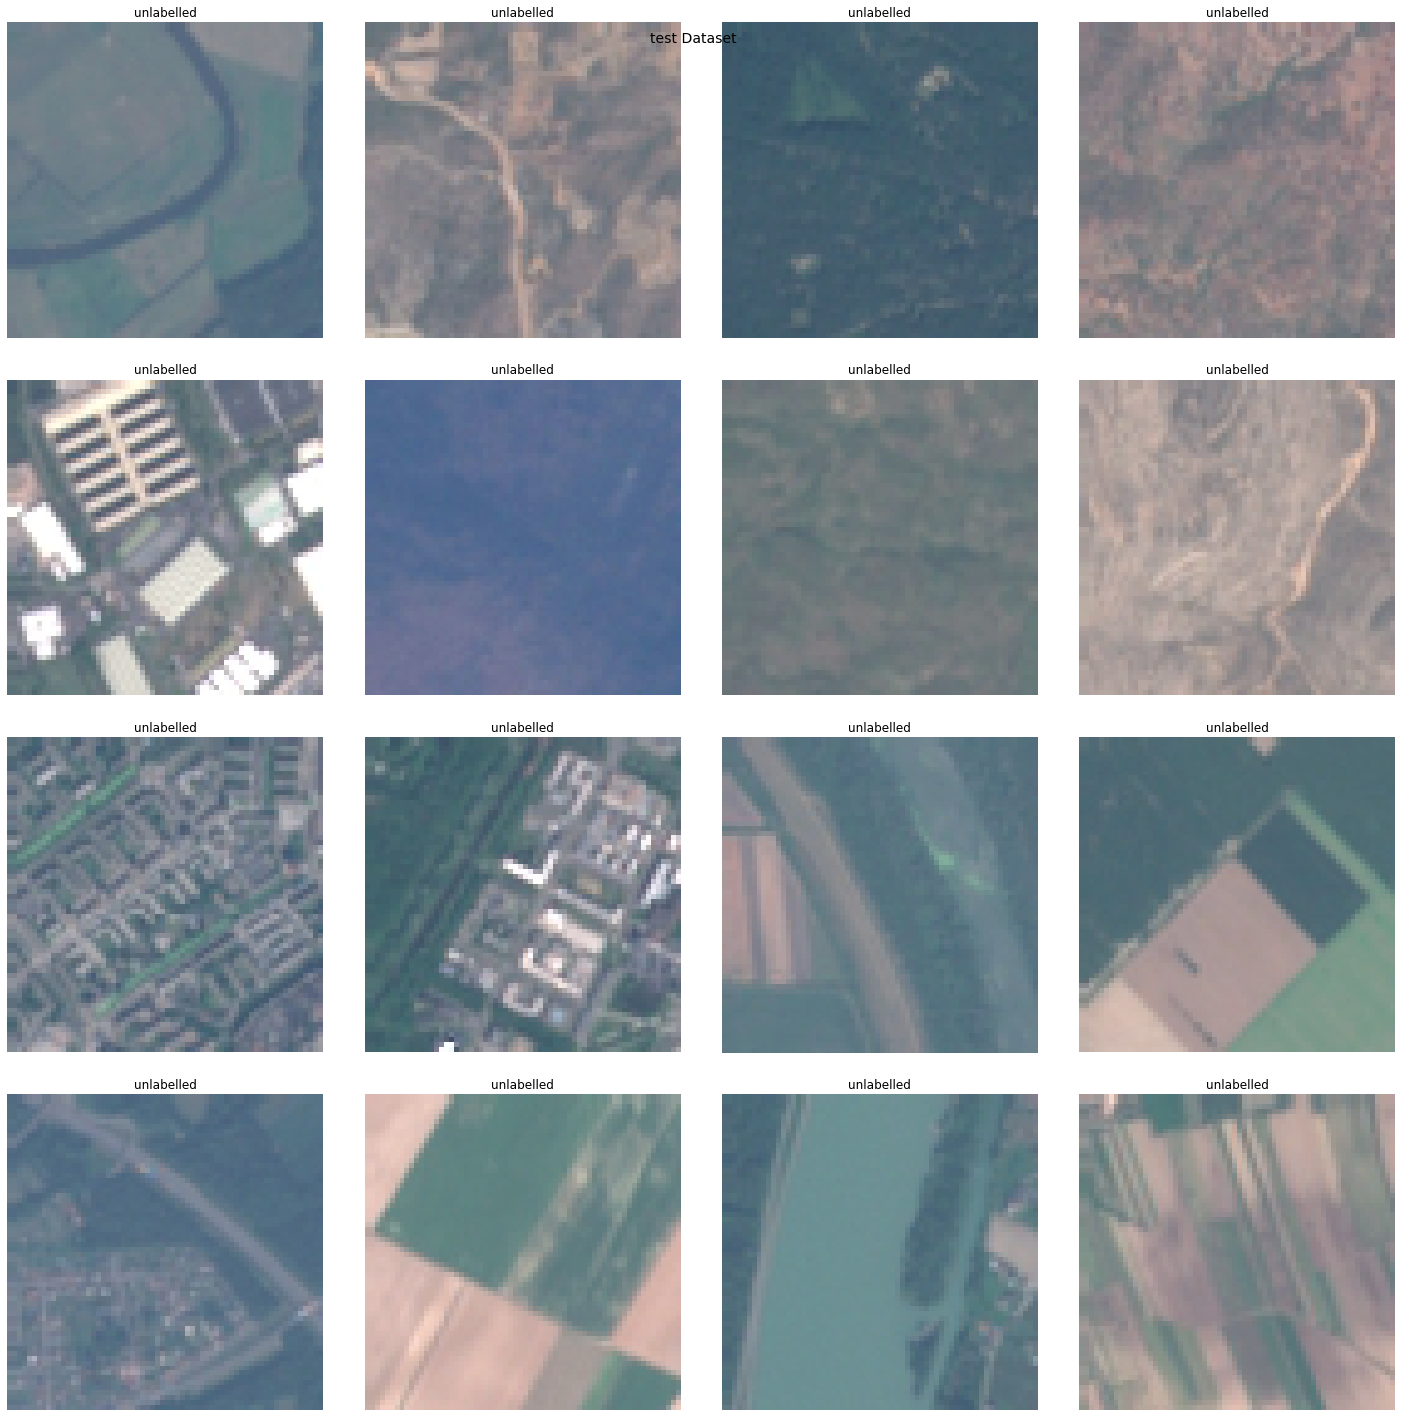

In [7]:
x_test.shape
plot_imgs(x_test, y=None, title="test Dataset")

In [8]:
model = torch.load("./model.pt")

In [9]:
def my_super_model(image):
    """
    Fonction de prédiction qui renvoie la classe (index) prédite par le modèle
    """

    # preprocessing sur l'image
    x = image.astype(np.float32) / 255.
    x = np.transpose(x, (2, 0, 1))
    x = x[None, :, :]

    # prédiction (index !)
    y_pred = model(torch.tensor(x))
    y_pred = y_pred.detach().numpy()

    y_pred = np.argmax(y_pred)
    return y_pred


def make_submission(predictions):
    """
    Génère un dataframe de soumission pour la compétition
    predictions est une liste de couples (idx, class_index)
    Exemple [(0,1),(1,9),(2,4)]"""
    df = []
    for idx, y_pred in predictions:
        cls_str = CLASSES[y_pred]
        df.append({"Id": idx, "Category": cls_str})
    df = sorted(df, key=lambda x: x["Id"])
    df = pd.DataFrame(df)
    return df

In [10]:
predictions = []

for idx, img in enumerate(x_test):
    y_pred = my_super_model(img)
    predictions.append((idx, y_pred))

submission_csv = make_submission(predictions)

In [11]:
# print du dataframe
submission_csv

,Id,Category
0,0,Highway
1,1,Residential
2,2,SeaLake
3,3,SeaLake
4,4,Highway
...,...,...
19995,19995,SeaLake
19996,19996,Industrial
19997,19997,Residential
19998,19998,Industrial


In [12]:
experiment_name = "essai_soumission_{}.csv".format(datetime.datetime.now().strftime("%Y%m%d_%H%M"))
# Sauvegarde du dataframe en csv. ATTENTION: index=False sinon BUG !
submission_csv.to_csv('./{}.csv'.format(experiment_name), index=False)